# Introducing Spectacle

Spectacle is an automated line finding and analysis package written in Python. Its primary use revolves around generating spectral models either explicitly, or as a reduction of input spectral data.

- GitHub: https://github.com/misty-pipeline/spectacle
- Docs: https://spectacle-py.rtfd.io

## Basic model generation

Spectacle provides an easy way to define spectral lines, characterized by their column densities, doppler b parameters, and their offsets. These are added to a spectral model object, containing methods with which the spectrum can be altered (e.g. LSFs, redshift, etc).

Ion information like oscillator strength and gamma values are determined by an internal lookup table which Spectacle references by finding the closest matching $\lambda_0$ or ion name defined in the table.

In [1]:
# Imports
from spectacle.modeling import Spectral1D, OpticalDepth1D
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings for the notebook demonstration
import warnings
warnings.filterwarnings('ignore')

# Suppress info messages for the notebook demonstration
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

spectacle [WARNING ]: 'generic loader' data loader provided for Spectrum1D without explicit identifier or list of compatible extensions
spectacle [WARNING ]: 'super_generic' data loader provided for Spectrum1D without explicit identifier or list of compatible extensions


In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 4]

We go ahead and define some ions we wish to use in the spectral model. Note that in the first case, the ion is defined by its $\lambda_0$ value. In the second, we use its lookup table name.

In [3]:
line1 = OpticalDepth1D(lambda_0=1216 * u.AA, v_doppler=20 * u.km/u.s, column_density=13.5)
line2 = OpticalDepth1D("OVI1038", v_doppler=30 * u.km/u.s, column_density=14)

Spectral models are created with the `Spectral1D` class. We pass in the lines we defined above. Alternatively, we could have defined the lines as a list of names or $\lambda_0$ values and passed them in as the first argument. In that case, the parameters of the individual lines would be implicitly set to the internal defaults.

The `Spectral1D` class also handles the input of the redshift at which the output flux values will be shown. Likewise, it is also here that we define the continuum to use for the spectrum. The continuum can be a numerical value, or an Astropy model.

The `output` keyword determines whether the resulting data from evaluating the spectral model is flux, flux decrement, or optical depth. Here, we will just use `flux`. The `rest_wavelength` keyword argument is used for cases where multiple ions are given and the input dispersion is in velocity space. This is not necessary if the dispersion is given in wavelength space.

Note also that we query the ion lookup table to get the exact value of `HI1216`, users can of course input a specific quantity themselves.

In [4]:
from spectacle.registries import line_registry

rest_wave = line_registry.with_name("HI1216")['wave']

spec_mod = Spectral1D([line1, line2], z=0, continuum=1, output='flux', rest_wavelength=rest_wave)

Now that we've defined our spectral model, we need only plot it. To do so, we must pass it a dispersion in either wavelength or velocity space. Note that the dispersion must be an Astropy quantity, with proper units.

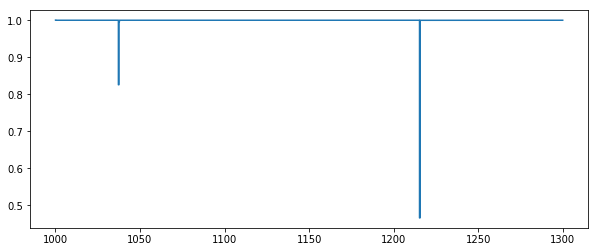

In [5]:
# Define dispersion in wavelength space
wav = np.linspace(1000, 1300, 1000) * u.Angstrom

f, ax = plt.subplots()
ax.step(wav, spec_mod(wav))

We can view several lines of the same ion in velocity space. Let's add a new line to the spectral model and focus just on `HI1216`. We'll giveit a `\Delta v` so that the two `HI1216` lines don't appear on top of each other.

In [6]:
line3 = OpticalDepth1D("HI1216", v_doppler=20 * u.km/u.s, column_density=13, delta_v=40 * u.km/u.s)

spec_mod = spec_mod.with_line(line3)

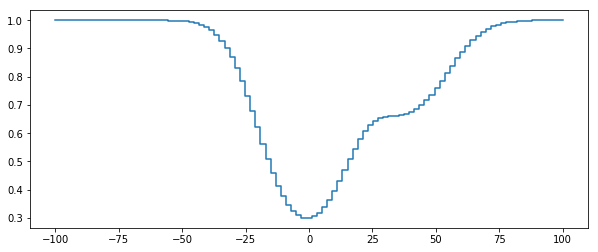

In [7]:
# Define the dispersion in wavelength space
vel = np.linspace(-100, 100, 100) * u.km/u.s

f, ax = plt.subplots()
ax.step(vel, spec_mod(vel))

We can check out our `OVI1038` line in velocity space as well, by adjusting the `rest_wavelength` on the spectral model.

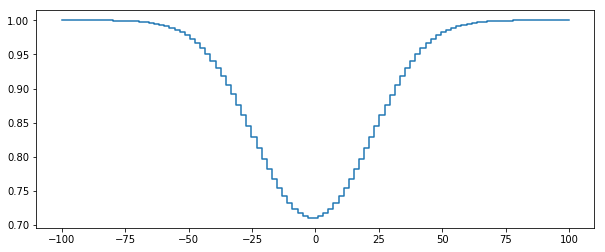

In [8]:
new_rest_wave = line_registry.with_name("OVI1038")['wave']

spec_mod.rest_wavelength = new_rest_wave

f, ax = plt.subplots()
ax.step(vel, spec_mod(vel))

### Extending the spectral model

The spectral model can be extended in many ways. Below, we show the effect of adding both the HST COS LSF as well as a Gaussian LSF with $sigma = 10$.

In [9]:
# Let's see the effect of the LSFs on the HI1216 lines
spec_mod.rest_wavelength = rest_wave

spec_mod_cos_lsf = spec_mod.with_lsf('cos')
spec_mod_gauss_lsf = spec_mod.with_lsf('gaussian', stddev=10)

vel = np.linspace(-75, 75, 150) * u.km/u.s
flux = spec_mod(vel)

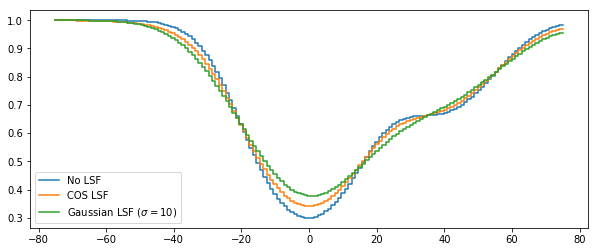

In [10]:
f, ax = plt.subplots()

ax.step(vel, flux, label="No LSF")
ax.step(vel, spec_mod_cos_lsf(vel), label="COS LSF")
ax.step(vel, spec_mod_gauss_lsf(vel), label="Gaussian LSF ($\sigma = 10$)")
plt.legend()

We can also set the spectral model to output values to a particular redshift by setting the `z` argument in the `Spectral1D` class, or by calling the `with_redshift` method on an already created one. We'll focus just on the `OVI` line so that the effect of higher redshifts is more obvious.

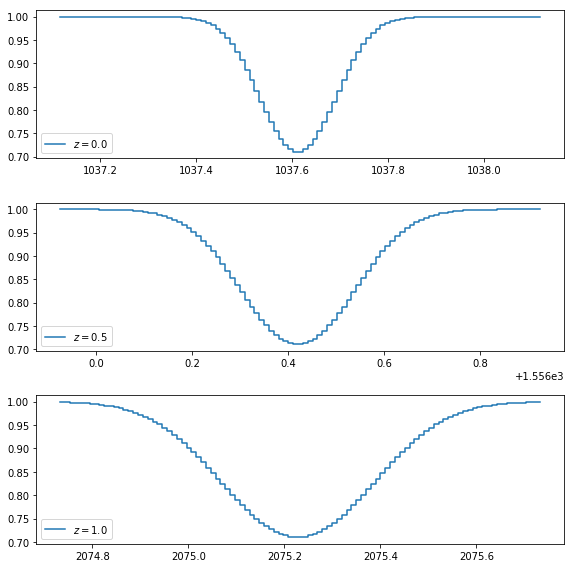

In [11]:
f, ax = plt.subplots(3, 1)

for i, z in enumerate(np.linspace(0.0, 1, 3)):
    new_mod = spec_mod.with_redshift(z)
    
    # Adjust the bounds of the dispersion to encompass the new redshift range
    xmin = new_mod.lines[1].lambda_0.value / (1/(1 + z)) - 0.5
    xmax = new_mod.lines[1].lambda_0.value / (1/(1 + z)) + 0.5
    
    w = np.linspace(xmin, xmax, 100) * u.AA
    
    ax[i].step(w, new_mod(w), label="$z={}$".format(z))
    ax[i].legend()
    
f.set_size_inches(8,8)
f.tight_layout()

## Generating models from data

Spectacle can also generate models automatically from input spectral data. This process uses a series of derivatives to find peaks and troughs, as well as bounding information, for each feature present in the spectrum. It then generates a line profile for each identified feature and constructs the `Spectral1D` model automatically.

We'll use line parameters from KODIAQ data to construct a spectal model that will serve to generate our initial raw data.

In [12]:
# Retrieve the data
from astropy.io import ascii

si4k = ascii.read("https://www.dropbox.com/s/sr24x6tdsagj6sn/tabfitsiiv.txt?dl=1")
si4k_los = si4k.group_by('LOS')
this_los = si4k_los.groups[0]

lines = []

for comp in range(len(this_los)):
    line_params = {
        'name': "SiIV1394",
        'delta_v': this_los['dv'][comp] * u.Unit('km/s'),
        'column_density': this_los['col'][comp],
        'v_doppler': this_los['b'][comp] * u.Unit('km/s')
    }
    
    lines.append(OpticalDepth1D(**line_params))

spectrum = Spectral1D(lines, output='flux', continuum=1)

vel = np.arange(-200, 75, 0.5) * u.Unit('km/s')
flux = spectrum(vel)

Text(0.5, 1.0, 'Raw KODIAQ Data')

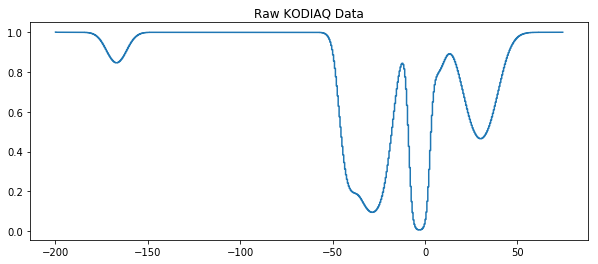

In [13]:
f, ax = plt.subplots()

ax.step(vel, flux)
ax.set_title("Raw KODIAQ Data")

Now that we have our raw KODIAQ data, we can setup our line finder to help us automatically recover the lines of the spectrum. The `LineFinder1D` class accepts a list of ions that represent a subset of the ion lookup table. This tells the line finder that potential lines can only be one of these ions. This is useful for finding lines in wavelength space, where several different ions may be present. The line finder will find the ion information closest to the centroid of the feature from the lookup table subset.

In our case, the entire spectrum is composed of `SiVI1394` and we're doing the line finding in velocity space, so we don't need to worry about that.

The `auto_fit` keyword tells the line finder to automatically run a Levenberg-Marquart LSQ fitter on the resulting spectral model. The `continuum` keyword is the same as the one we use when constructing a `Spectral1D` object. The `output` keyword is similar to that of the `Spectral1D` object and tells the line finder that the input data is expected to be a flux/flux decrement/optical depth value. The `threshold` tells the line finding routine how far beyond the continuum to start considering things absorption features.

Many fitting 

In [14]:
from spectacle.fitting import LineFinder1D

line_finder = LineFinder1D(ions=["SiIV1394"], auto_fit=True, continuum=1, output='flux', threshold=0.05)
result_spec_mod = line_finder(vel, flux)

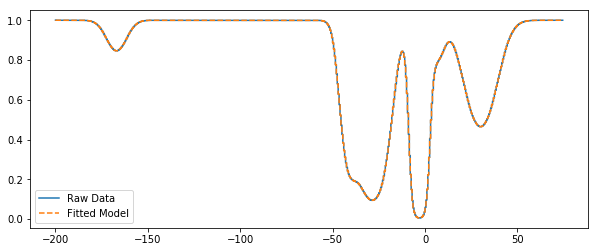

In [15]:
f, ax = plt.subplots()

ax.step(vel, flux, label='Raw Data')
ax.step(vel, result_spec_mod(vel), linestyle='--', label='Fitted Model')
ax.legend()

As we can see, the line finder did a pretty good job recoverying the absorption features of the spectrum. We can show the individual sub models representing each line to be sure that the correct number of features were identified.

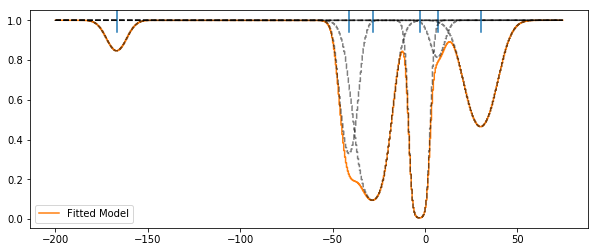

In [16]:
f, ax = plt.subplots()

ax.step(vel, result_spec_mod(vel), color='tab:orange', label='Fitted Model')

for line in result_spec_mod.lines:
    # The `reset` keyword means that the internal list of lists is dumped
    # and repopulated by the given line.
    line_mod = result_spec_mod.with_line(line, reset=True)
    
    ax.step(vel, line_mod(vel), linestyle='--', color='k', alpha=0.5)
    ax.axvline(line_mod.lines[0].delta_v.value, 0.9, 1.05)

ax.legend()

In [ ]:
### Retrieving fit uncertainties



## Line and region statistics

We can also retrieve statistical information for the individual lines and the blended regions of the spectral model. For both lines and regions, three statistics are calculated: the equivalent width, the velocity widget at 90% maximum, and the full-width at half-maximum.

The `line_stats` method takes a dispersion to use for calculating the statistics, and returns a table containing each individual line, their profile parameters, and the resulting statistics.

In [17]:
# Individual line statistics
line_stats = result_spec_mod.line_stats(vel)
line_stats

name,wave,col_dens,v_dop,delta_v,delta_lambda,ew,dv90,fwhm
,Angstrom,,km / s,km / s,Angstrom,Angstrom,km / s,Angstrom
bytes10,float64,float64,float64,float64,float64,float64,float64,float64
SiIV1394,1393.755,12.752299999990507,5.605299999962892,-40.89210000009751,0.0,0.046287621628031884,11.5,0.043445187748829994
SiIV1394,1393.755,11.99389999986455,5.25579999988895,6.962699999846056,0.0,0.04340044274678587,10.5,0.040737020589631356
SiIV1394,1393.755,12.047499999999998,7.359599999999964,-166.63369999997227,0.0,0.06073154132949377,16.0,0.05701332668968462
SiIV1394,1393.755,13.304200000002565,9.433000000067139,-28.20550000007709,0.0,0.07784731062291267,20.5,0.0730894540756708
SiIV1394,1393.755,13.291600000030016,4.221899999880106,-2.7874000000271097,0.0,0.03496634518718456,8.0,0.03279045885869891
SiIV1394,1393.755,12.878300000000305,10.858800000008156,30.30900000002311,0.0,0.0895994971486153,24.0,0.08413602131599873


The `region_stats` also take a dispersion array, as well as a rest wavelength value `rest_wavelength`. This is used to do conversions of the dispersion array between wavelength and velocity space. An additional parameter can be provided, `abs_tol`, which dictates to the region finder the threshold above the continuum at which a region can be defined.

In [18]:
# Region line statistics
reg_stats = result_spec_mod.region_stats(vel, rest_wavelength=1393.755 * u.Angstrom, abs_tol=0.05)
reg_stats

region_start,region_end,rest_wavelength,ew,dv90,fwhm
km / s,km / s,Angstrom,Angstrom,km / s,Angstrom
float64,float64,float64,float64,float64,float64
-175.0,-159.0,1393.755,0.052474361420837036,11.5,0.04474843249431615
-51.0,48.0,1393.755,0.23239506435475898,78.5,0.3575981653589224


We can plot the region information to get a better idea of what each found region encompasses.

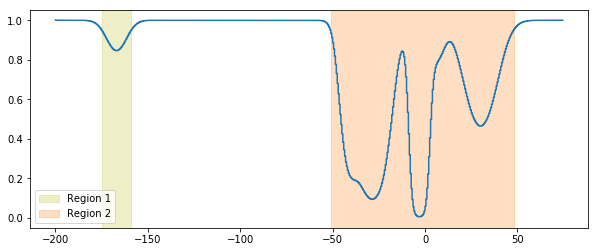

In [19]:
f, ax = plt.subplots()

ax.step(vel, flux)

clrs = ['tab:olive', 'tab:orange']

for i, row in enumerate(reg_stats):
    ax.fill_between(vel[(vel.value >= row['region_start'].value) & (vel.value <= row['region_end'].value)], 
                     -0.1, 1.5, color=clrs[i], alpha=0.25, label='Region {}'.format(i + 1))
    

ax.set_ylim(-0.05, 1.05)
ax.legend()